copy from https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/", one_hot=False)

W0830 06:11:48.680783 140370665338752 deprecation.py:323] From <ipython-input-1-d382e6246865>:3: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0830 06:11:48.683428 140370665338752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0830 06:11:48.685184 140370665338752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./mnist/train-images-idx3-ubyte.gz


W0830 06:11:49.615010 140370665338752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/t10k-images-idx3-ubyte.gz


W0830 06:11:50.145036 140370665338752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [0]:
!mkdir images
!mkdir mnist

In [0]:

# Large amount of credit goes to:
# https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py
# which I've used as a reference for this implementation

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=30000, batch_size=32, sample_interval=100)

epoch :  0


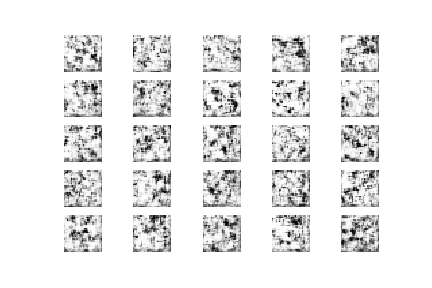

epoch :  1000


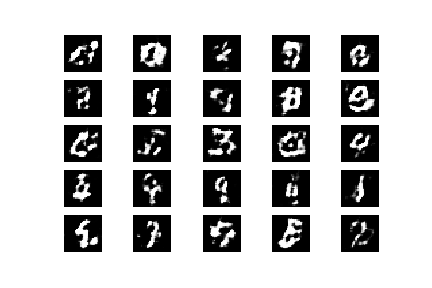

epoch :  2000


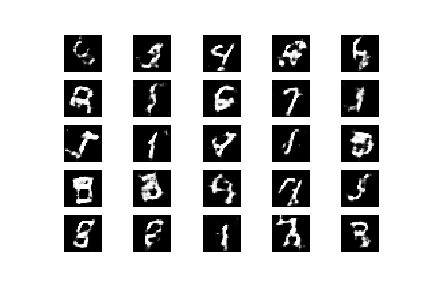

epoch :  3000


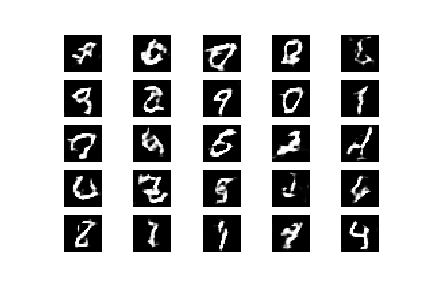

epoch :  4000


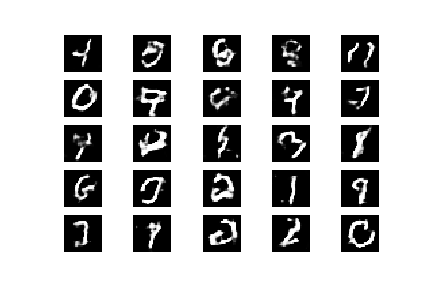

epoch :  5000


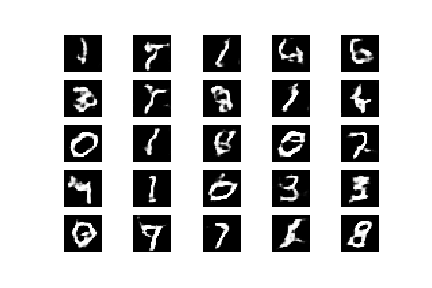

epoch :  6000


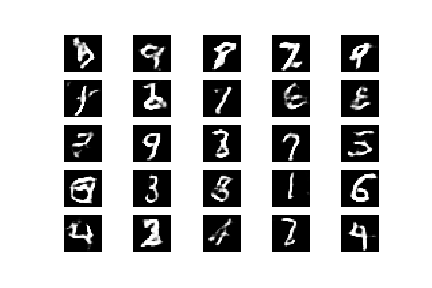

epoch :  7000


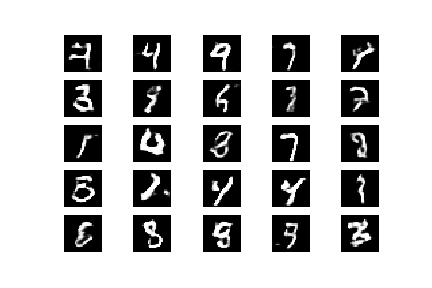

epoch :  8000


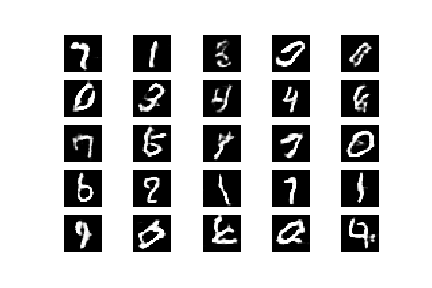

epoch :  9000


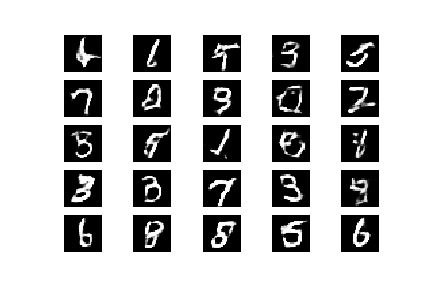

epoch :  10000


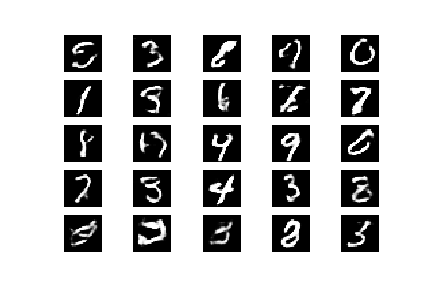

epoch :  11000


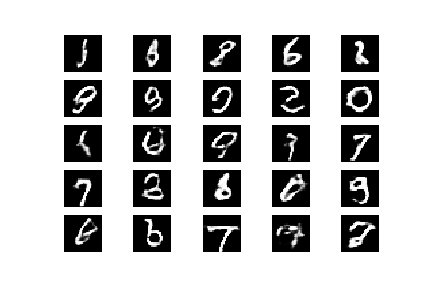

epoch :  12000


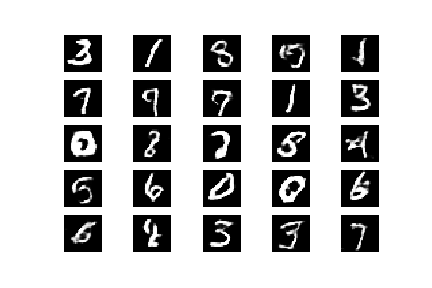

epoch :  13000


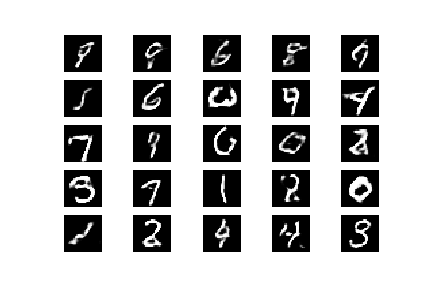

epoch :  14000


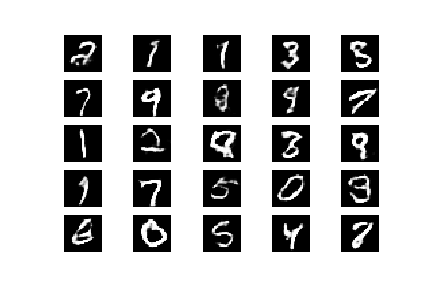

epoch :  15000


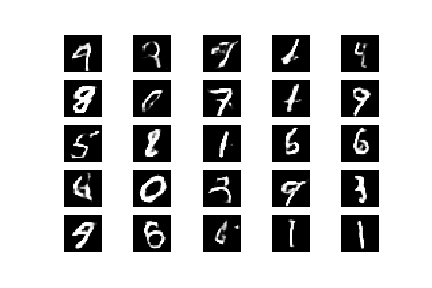

epoch :  16000


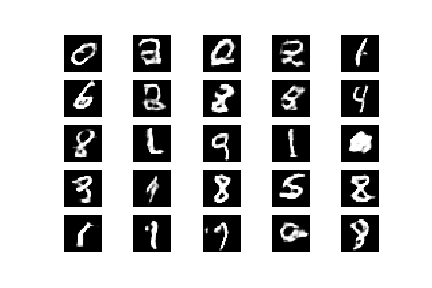

epoch :  17000


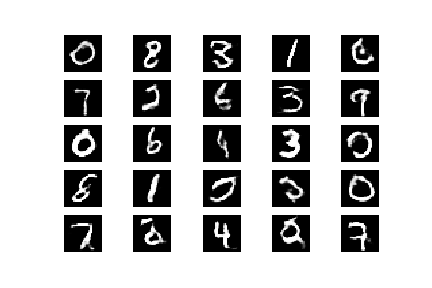

epoch :  18000


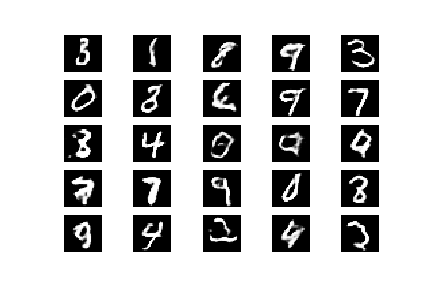

epoch :  19000


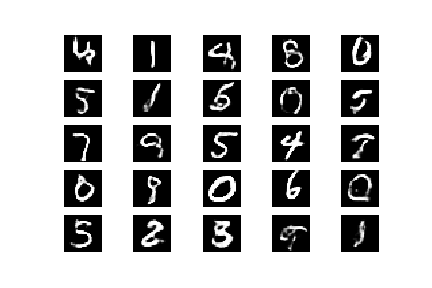

epoch :  20000


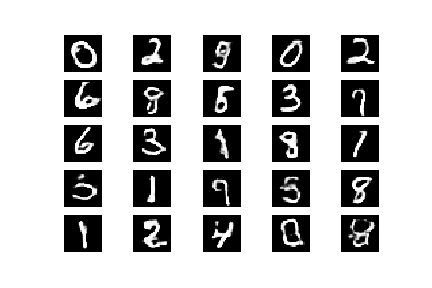

epoch :  21000


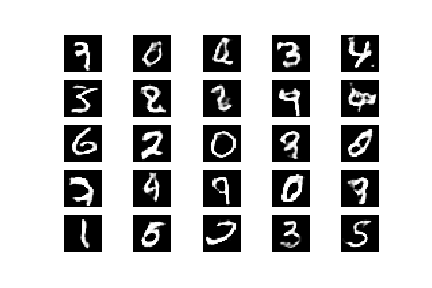

epoch :  22000


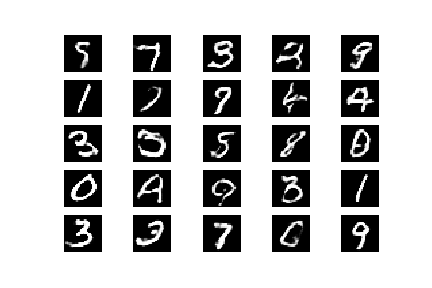

epoch :  23000


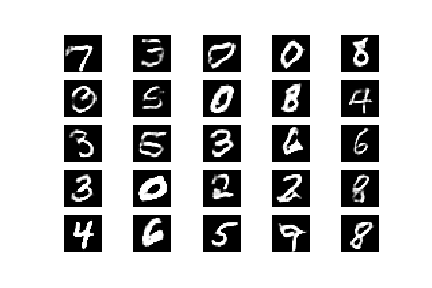

epoch :  24000


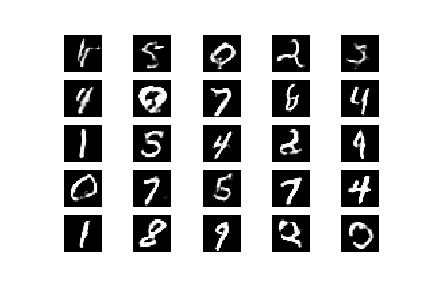

In [0]:
from IPython.display import Image
for i in range(0,25000,1000):
  print("epoch : ",i)
  display(Image('images/mnist_{}.png'.format(i)) )